# Segmentation of Medical Scans using Variational VAE's - Part 3/3
This series of notebooks enables reproduceability of our final models and testing results.

The third notebook goes through the process of creating, training and tuning a variational decoder, which will act as a segmenter.

We import some necessary libraries, and check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large. We setup up some global constants.

In [1]:
# For ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from torch import Tensor

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt

# For monitoring resource-usage and progress.
from timeit import default_timer as timer
import psutil
from os.path import join

# Our own utility functions, constants and classes.
from utility import CT_Dataset, superimpose, draw, IoU

# Our own DL models.
from models import VAEModel, SegmentationModel, Conv, ConvTranspose

# Paths.
root_dir = '../' # Relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'prep_data')
losses_dir = join(root_dir, 'losses')
models_dir = join(root_dir, 'saved_models')
checkpoint_dir = join(root_dir, 'checkpoints')


# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce GTX 1070
CUDA version: 11.7
RAM: 16.74GB


We define a new function to create dataloaders - This time splitting the dataset into a training-, development- and testing-set.

In [2]:
def make_seg_loaders(data, batch_size):
    N = len(data); N_train = int(0.8*N); 
    N_dev = int((N - N_train)/2); N_test = int(N - N_train - N_dev)
    train_data, dev_data, test_data = D.random_split(data, [N_train, N_dev, N_test])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    test_loader = D.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader, test_loader

Once again, we create an instance of the full dataset, and pass it the dataloader creator. Naturally, we use the same resolution and batch-size.

In [3]:
resolution = 2**8; batch_size = 32;
dataset = CT_Dataset(prep_data_dir, 'lung', resolution)
train_loader, dev_loader, test_loader = make_seg_loaders(dataset, batch_size)

This time, we simply use a binary-cross-entropy loss-function.

We also define a training-routine for a single epoch, i.e. a full round of training data, as well as an evaluation routine. These routines are different from the routines in the previous notebook.

In [4]:
loss_fn = nn.BCELoss(reduction='sum')

def train_epoch(vae_model, seg_model, optimizer, train_loader):
    seg_model.train()
    vae_model.eval()
    losses = 0
    
    for batch in train_loader:
        x = batch[0].to(device) # Batch of images.
        y = batch[1].to(device) # Batch of labels.
        optimizer.zero_grad()
        z = vae_model.forward_latent(x) # Get latent vector from VAE.
        y_hat = seg_model.forward(z) # Reconstruction from new decoder.
        loss = loss_fn(y_hat, y) # Compare reconstruction to label.
        loss.backward()
        optimizer.step()
        losses += loss.item()   
    
    return losses / len(train_loader)  # average loss

def evaluate(vae_model, seg_model, dev_loader):
    seg_model.eval()
    vae_model.eval()
    losses = 0

    for data in dev_loader:
        x = data[0].to(device)
        y = data[1].to(device)
        z = vae_model.forward_latent(x)
        y_hat = seg_model.forward(z)
        loss = loss_fn(y_hat, y)
        losses += loss.item() 
    return losses / len(dev_loader)

We load in our trained model, which we created in the previous notebook.

In [5]:
vae_model = torch.load(join(models_dir, 'vae_model.pt')).to(device)

We create an untrained instance of our `SegmentationModel` class, which we have defined in the `models.py` file. We specify an optimizer, as well as a learning rate scheduler. Again, we found that the `AdamW` optimizer, which is Adam with weight-decay, works slightly better than regular `Adam`. 

In [6]:
seg_model = SegmentationModel(base=16).to(device)

optimizer = optim.AdamW(seg_model.parameters(), lr=3e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

Training a single decoder is a lot faster than a full VAE, so we do not need checkpointing.

In [7]:
total_epochs = 10

train_losses = []; dev_losses = []; lrs = []

try:
    for epoch in range(1, total_epochs+1):
        lrs.append(optimizer.param_groups[0]['lr'])
        start_time = timer()
        train_loss = train_epoch(vae_model, seg_model, optimizer, train_loader)
        train_losses.append(train_loss)
        end_time = timer()
        dev_loss = evaluate(vae_model, seg_model, dev_loader)
        dev_losses.append(dev_loss)
        scheduler.step()
        
        print((f"Epoch {epoch}:, Train-loss: {train_loss:.4f}, Dev-loss: {dev_loss:.4f}, "f"Epoch-time = {(end_time - start_time):.3f}s"))

    print('Training completed.')
    
except KeyboardInterrupt:
    print('Manually stopped.')

Epoch 1:, Train-loss: 36120.0959, Dev-loss: 7806.1140, Epoch-time = 60.387s
Epoch 2:, Train-loss: 5998.8241, Dev-loss: 6776.2950, Epoch-time = 58.966s
Epoch 3:, Train-loss: 5505.4892, Dev-loss: 6080.4452, Epoch-time = 60.609s
Epoch 4:, Train-loss: 5216.1273, Dev-loss: 6028.6627, Epoch-time = 61.397s
Epoch 5:, Train-loss: 5057.5954, Dev-loss: 5607.3545, Epoch-time = 61.969s
Epoch 6:, Train-loss: 4721.9294, Dev-loss: 5500.6825, Epoch-time = 62.201s
Epoch 7:, Train-loss: 4514.6320, Dev-loss: 5258.3973, Epoch-time = 62.685s
Epoch 8:, Train-loss: 4255.1332, Dev-loss: 4961.3076, Epoch-time = 62.922s
Epoch 9:, Train-loss: 3951.8923, Dev-loss: 4479.3951, Epoch-time = 62.524s
Epoch 10:, Train-loss: 3595.4512, Dev-loss: 4093.9116, Epoch-time = 62.825s
Training completed.


We save the trained segmentation model along with loss metrics.

In [11]:
# CAREFUL NOT TO OVERWRITE. Set flags.
model_num = 4; save = True

if save:
    torch.save(seg_model,
        join(models_dir, 'seg_model_' + str(model_num) + '.pt'))

    torch.save(train_losses,
        join(losses_dir, 'seg_train_losses_' + str(model_num) + '.pt'))

    torch.save(dev_losses,
        join(losses_dir, 'seg_dev_losses_'  + str(model_num) + '.pt'))

We can now load in our models.

In [9]:
#vae_model = torch.load(join(models_dir, 'vae_model.pt')).to(device)
#seg_model = torch.load(join(models_dir, 'seg_model.pt')).to(device)

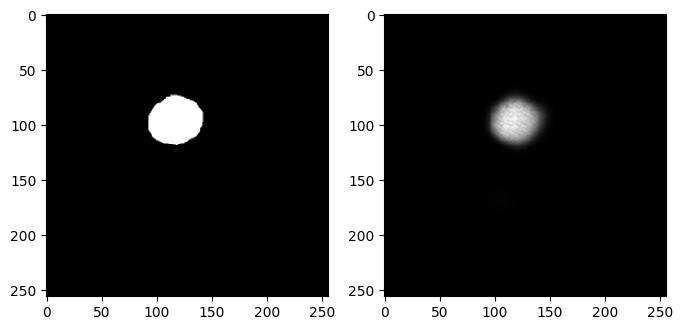

In [40]:
# Tell models to not update weights.
vae_model.eval()
seg_model.eval()

# Get single batch.
image, label = next(iter(dev_loader))

x = image[1][None, :].to(device) # Batch of 1 image.
y = label[1][None, :].to(device) # Batch of 1 label.

# Pass through our models.
z = vae_model.forward_latent(x)
y_hat = seg_model.forward(z)

truth = torch.squeeze(y.cpu()).detach().numpy()
guess = torch.squeeze(y_hat.cpu()).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(8,5))
axs[0].imshow(truth,cmap='gray')
axs[1].imshow(guess,cmap='gray')
fig.canvas.draw()